# Immunofluorescence images

In [1]:
from os.path import expanduser,exists
from os import walk
import numpy as np
import gudhi as gd
import multipers as mp
import matplotlib.pyplot as plt
from pandas import read_csv
from sklearn.preprocessing import LabelEncoder
from multipers.plots import plot_signed_measure, plot_surface

## Dataset

This dataset can be retrieved at [this address](https://github.com/MultiparameterTDAHistology/SpatialPatterningOfImmuneCells).

In [2]:
def get_immuno(i, DATASET_PATH=expanduser("~/Datasets/")):
    immu_dataset = read_csv(DATASET_PATH+f"LargeHypoxicRegion{i}.csv")
    X = np.array(immu_dataset['x'])
    X /= np.max(X)
    Y = np.asarray(immu_dataset['y'])
    Y /= np.max(Y)
    labels = LabelEncoder().fit_transform(immu_dataset['Celltype'])
    return np.concatenate([X[:,None], Y[:,None]], axis=1), labels

In [3]:
X, labels = get_immuno(1)
idx = labels<=1 # we only take two labels for the plot
x = X[idx]
y = labels[idx]

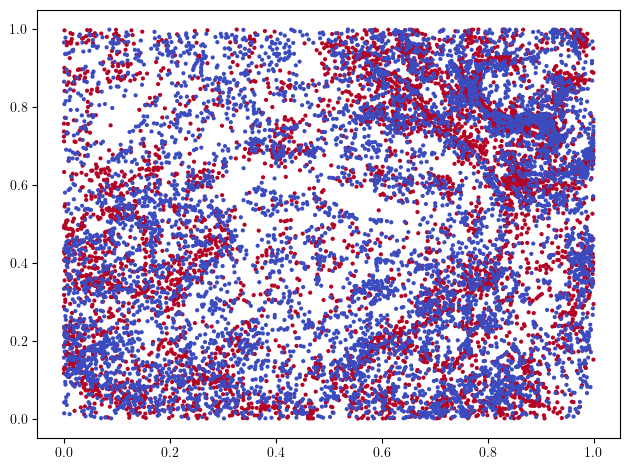

In [4]:
plt.scatter(*x.T, s=4, c=y, cmap="coolwarm")

We turn this dataset into an image, by evaluating a density estimation of each protein.

In [5]:
from multipers.filtrations.density import KDE
## to provide plots, we only consider 2 parameters.
## The rest of the code should still work without this constraint
_labels = [0,2] # np.unique(labels)
resolution=100
grid = mp.grids.compute_grid(np.asarray([[0,1.]]*X.shape[1]), strategy="regular", resolution=resolution, dense=True)
densities = np.concatenate([KDE(bandwidth=.01, return_log=True).fit((x:=X[labels==idx])).score_samples(grid).reshape(*[resolution]*X.shape[1],1) for idx in _labels], axis=-1)

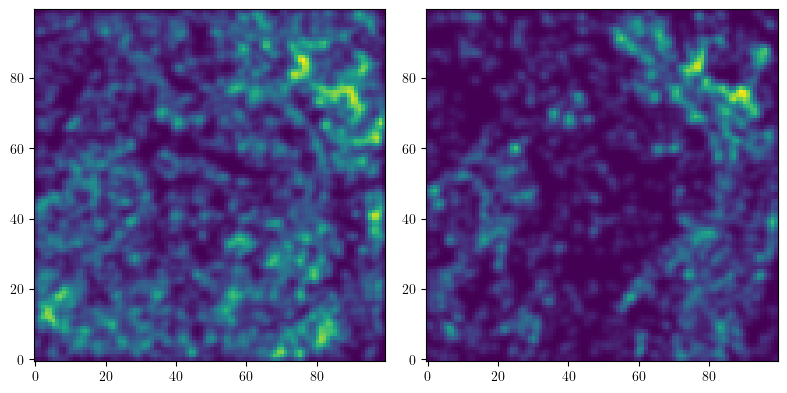

In [6]:
fig, axes = plt.subplots(ncols=len(_labels), figsize=(len(_labels)*4, 4))
for i,ax in enumerate(np.asarray(axes).reshape(-1)):
    plt.sca(ax)
    out = plt.imshow(np.exp(densities[...,i]), origin="lower")
    # plt.colorbar(out)

## Invariants from multifiltered image

`densities` is an image of shape `(100,100,num_parameters)`. 
This can be directly given to the `Cubical` filtration constructor, 
to encode the filtration given by the sublevelsets of these images.

In [7]:
from multipers.filtrations import Cubical
cubical = Cubical(-densities) ## higher densities appear first
cubical

slicer[backend=Matrix,dtype=float64,num_param=2,vineyard=False,kcritical=False,is_squeezed=False,is_minpres=False,max_dim=2]

Note that in the 2-parameter case, the computations can be reduced with minimal presentations or edge collapses.

The resolution of the cubical complex is low enough here, so we don't need it.

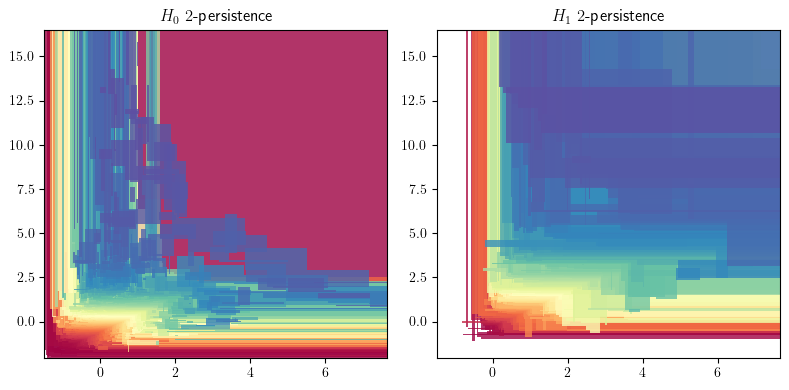

In [8]:
## module_approximation needs a vineyard backend
_s = mp.Slicer(cubical, backend="matrix", vineyard=True).minpres(degrees=[0,1])
mod = mp.module_approximation(_s)
mod.plot(alpha =.8)

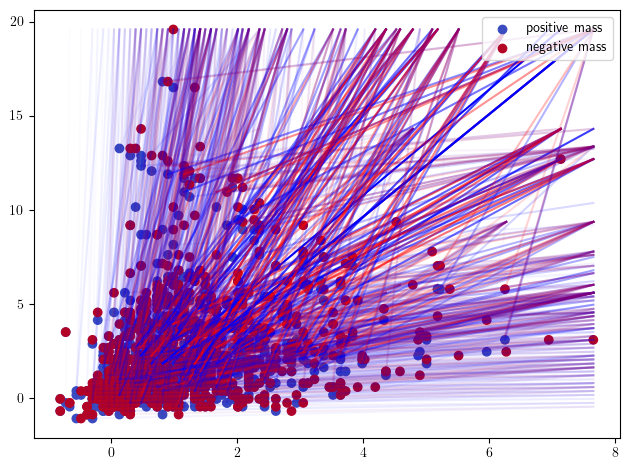

In [9]:
## The rank invariant and hilbert function seen as signed measures
degree = 1
_s =(
    mp.Slicer(cubical, vineyard=False, backend = "gudhicohomology")
    .minpres(degree)
    .grid_squeeze(strategy="regular_closest", resolution=100) # coarsen the filtration
) ## reduces the complex via a minimal presentation, on a coarsened grid
smr = mp.signed_measure(_s,invariant ="rank", degree=degree, plot=True);
smh = mp.signed_measure(_s, invariant="hilbert", degree=degree,plot=True);

## Some representations of this bifiltration, from previous invariant

In order to use these invariants in a machine learning context, one possibility is 
to turn them into vectors

### MMA representation

MMA modules can easily be represented via, e.g., the `representation` method.

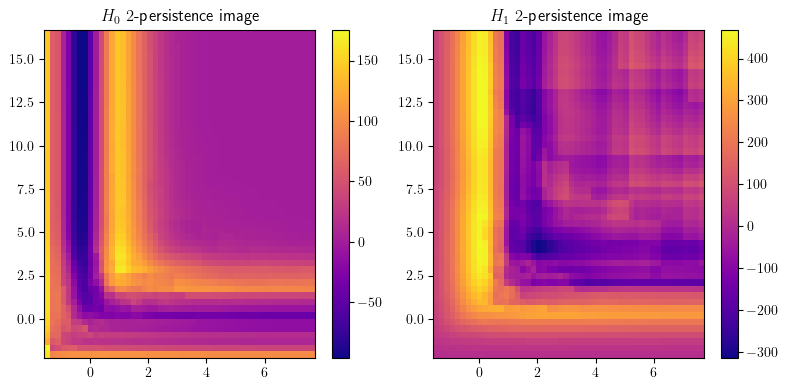

In [10]:
## Some kernel for a representation via mma decompositions
def soft_sign(x,b=100):
    return (b*x)/(b*np.abs(x)+1)
def kernel(D, w):
    signs=soft_sign(D)
    return (signs*np.exp( -.5*(D**2))*w).sum(1) ## Exponential kernel
mod.representation(bandwidth=1,plot=True, signed=True,kernel=kernel);
# mod.plot()

And signed measures can also be turned into a vector via a simple convolution

### Signed measure representation

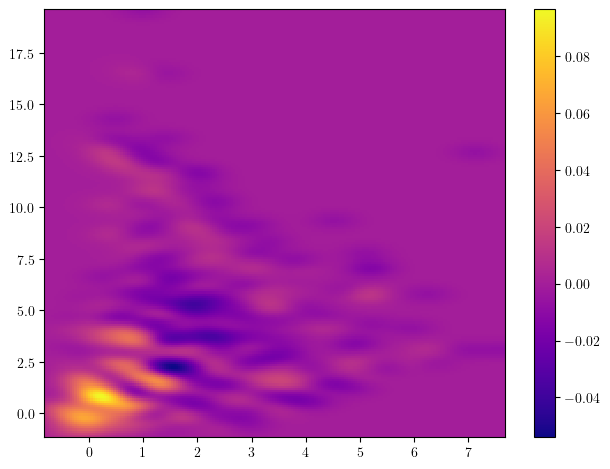

In [11]:
## The Hilbert signed measure, convolved with an exponential kernel
from multipers.filtrations.density import convolution_signed_measures
img_grid = mp.grids.compute_grid(smh, strategy="regular", resolution=200)
img = convolution_signed_measures([smh], img_grid, bandwidth=.1, flatten=False, kernel = "exponential")
stuff= plot_surface(img_grid, img.squeeze(), cmap="plasma")
plt.colorbar(stuff)